# Generic HMC 

### Imports

In [14]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from l2hmc_eager import dynamics_eager as _l2hmc
from l2hmc_eager import gauge_dynamics_eager as l2hmc
from l2hmc_eager.neural_nets import *
from utils.distributions import GMM, gen_ring
from utils.jacobian import _map, jacobian
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

from HMC.hmc import HMC

from lattice.gauge_lattice import GaugeLattice, pbc, mat_adj, u1_plaq_exact

%autoreload 2

In [1]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

Using TensorFlow backend.


In [17]:
def train_one_iter(dynamics, x, optimizer, loss_fn=l2hmc.compute_loss, 
                   scale=0.1, eps=1e-4, l2_dist=True, global_step=None):
    loss, grads, out, accept_prob = l2hmc.loss_and_grads(
        dynamics, x, loss_fn=loss_fn, scale=scale, eps=eps, l2_dist=l2_dist
    )
    gradients, _ = tf.clip_by_global_norm(grads, 10.)
    optimizer.apply_gradients(
        zip(grads, dynamics.trainable_variables), global_step=global_step
    )
    return loss, out, accept_prob

## 2D $U(1)$ Lattice Gauge Theory

In [2]:
time_size, space_size, dim, beta, num_samples = (8, 8, 2, 3., None)
link_type = 'U1'
lattice = GaugeLattice(time_size=time_size,
                       space_size=space_size,
                       dim=dim,
                       beta=beta,
                       link_type=link_type,
                       num_samples=num_samples, rand=True)
#samples = np.array([sample.flatten() for sample in lattice.samples])
lattice_energy_fn = lattice.get_energy_function()

In [3]:
step_size = 0.1
n_leapfrog_steps = 5
#position_init = samples
position_init = lattice.links.flatten()
lattice_hmc = HMC(position_init=position_init,
                  step_size=step_size,
                  n_leapfrog_steps=n_leapfrog_steps,
                  potential_fn=lattice_energy_fn,
                  beta=lattice.beta)

In [4]:
links0 = lattice.links.flatten()
momentum0 = np.random.randn(*links0.shape)
links_arr = [links0]
vel_arr = []
probs_arr = []
total_actions = []
average_plaquettes = []
topological_charges = []
links1 = links0
num_steps = 500
print('Exact value of the average plaquette '
      f'(at {beta}): {u1_plaq_exact(beta)}\n')
for i in range(num_steps):
    links1, vel1, probs1 = lattice_hmc.apply_transition(links1)
    
    observables = np.array(lattice._calc_plaq_observables(links1))
    _total_actions = observables[0]
    _avg_plaquettes = observables[1]
    _top_charges = observables[2]
    
    total_actions.append(_total_actions)
    average_plaquettes.append(_avg_plaquettes)
    topological_charges.append(_top_charges)
    print(f'\nstep: {i:<5g} accept rate: {np.mean(probs1):^8.5g}  '
      #f' time/step: {time.time() - t1:^6.4g} '
      f' avg_S: {np.mean(_total_actions):^8.5g} '
      f' avg_topQ: {np.mean(_top_charges):^8.5g} '
      f' avg_plaq: {np.mean(_avg_plaquettes):^8.5g}\n ')

Exact value of the average plaquette (at 3.0): 0.8099852939565045


step: 0     accept rate:    1       avg_S:  102.62   avg_topQ:  4.7418   avg_plaq: 0.46553 
 

step: 1     accept rate:    1       avg_S:  49.81    avg_topQ:  7.5434   avg_plaq: 0.74057 
 

step: 2     accept rate:    1       avg_S:  34.087   avg_topQ:  8.3775   avg_plaq: 0.82246 
 

step: 3     accept rate: 0.84691    avg_S:  34.087   avg_topQ:  8.3775   avg_plaq: 0.82246 
 

step: 4     accept rate: 0.92092    avg_S:  42.799   avg_topQ:  7.9154   avg_plaq: 0.77709 
 

step: 5     accept rate: 0.93676    avg_S:  42.799   avg_topQ:  7.9154   avg_plaq: 0.77709 
 

step: 6     accept rate:  0.9511    avg_S:  45.365   avg_topQ:  7.7792   avg_plaq: 0.76372 
 

step: 7     accept rate: 0.94949    avg_S:  47.422   avg_topQ:  7.6701   avg_plaq: 0.75301 
 

step: 8     accept rate: 0.91935    avg_S:  47.422   avg_topQ:  7.6701   avg_plaq: 0.75301 
 

step: 9     accept rate:    1       avg_S:  43.96    avg_topQ:  7.8538   avg_


step: 86    accept rate: 0.81784    avg_S:  37.821   avg_topQ:  8.1794   avg_plaq: 0.80301 
 

step: 87    accept rate:    1       avg_S:  34.165   avg_topQ:  8.3734   avg_plaq: 0.82206 
 

step: 88    accept rate: 0.86755    avg_S:  38.616   avg_topQ:  8.1373   avg_plaq: 0.79887 
 

step: 89    accept rate: 0.99846    avg_S:  39.314   avg_topQ:  8.1002   avg_plaq: 0.79524 
 

step: 90    accept rate:    1       avg_S:  22.798   avg_topQ:  8.9764   avg_plaq: 0.88126 
 

step: 91    accept rate:  0.8364    avg_S:  28.756   avg_topQ:  8.6603   avg_plaq: 0.85023 
 

step: 92    accept rate: 0.94607    avg_S:  31.238   avg_topQ:  8.5287   avg_plaq:  0.8373 
 

step: 93    accept rate: 0.99375    avg_S:  28.839   avg_topQ:  8.656    avg_plaq:  0.8498 
 

step: 94    accept rate:    1       avg_S:  30.772   avg_topQ:  8.5534   avg_plaq: 0.83973 
 

step: 95    accept rate: 0.87401    avg_S:  30.772   avg_topQ:  8.5534   avg_plaq: 0.83973 
 

step: 96    accept rate: 0.61384    avg_S:  30.77


step: 173   accept rate: 0.82897    avg_S:  39.631   avg_topQ:  8.0834   avg_plaq: 0.79359 
 

step: 174   accept rate: 0.86192    avg_S:  41.362   avg_topQ:  7.9916   avg_plaq: 0.78457 
 

step: 175   accept rate:    1       avg_S:  36.769   avg_topQ:  8.2353   avg_plaq:  0.8085 
 

step: 176   accept rate:    1       avg_S:  33.45    avg_topQ:  8.4113   avg_plaq: 0.82578 
 

step: 177   accept rate: 0.83276    avg_S:  46.869   avg_topQ:  7.6995   avg_plaq: 0.75589 
 

step: 178   accept rate: 0.99817    avg_S:  44.444   avg_topQ:  7.8281   avg_plaq: 0.76852 
 

step: 179   accept rate: 0.91945    avg_S:  37.21    avg_topQ:  8.2119   avg_plaq:  0.8062 
 

step: 180   accept rate:    1       avg_S:  38.85    avg_topQ:  8.1249   avg_plaq: 0.79766 
 

step: 181   accept rate:    1       avg_S:  34.159   avg_topQ:  8.3737   avg_plaq: 0.82209 
 

step: 182   accept rate:    1       avg_S:  31.922   avg_topQ:  8.4924   avg_plaq: 0.83374 
 

step: 183   accept rate:    1       avg_S:  30.57


step: 260   accept rate: 0.90143    avg_S:  44.237   avg_topQ:  7.8391   avg_plaq:  0.7696 
 

step: 261   accept rate:    1       avg_S:  40.037   avg_topQ:  8.0619   avg_plaq: 0.79147 
 

step: 262   accept rate:    1       avg_S:  38.605   avg_topQ:  8.1379   avg_plaq: 0.79893 
 

step: 263   accept rate:    1       avg_S:  22.589   avg_topQ:  8.9875   avg_plaq: 0.88235 
 

step: 264   accept rate: 0.67941    avg_S:  31.651   avg_topQ:  8.5068   avg_plaq: 0.83515 
 

step: 265   accept rate:    1       avg_S:  25.978   avg_topQ:  8.8077   avg_plaq:  0.8647 
 

step: 266   accept rate: 0.78665    avg_S:  33.609   avg_topQ:  8.4029   avg_plaq: 0.82495 
 

step: 267   accept rate:    1       avg_S:  30.297   avg_topQ:  8.5786   avg_plaq:  0.8422 
 

step: 268   accept rate: 0.96053    avg_S:  32.955   avg_topQ:  8.4376   avg_plaq: 0.82836 
 

step: 269   accept rate:    1       avg_S:  33.574   avg_topQ:  8.4047   avg_plaq: 0.82513 
 

step: 270   accept rate: 0.76084    avg_S:  44.62


step: 347   accept rate:    1       avg_S:  33.106   avg_topQ:  8.4296   avg_plaq: 0.82757 
 

step: 348   accept rate:    1       avg_S:  31.38    avg_topQ:  8.5212   avg_plaq: 0.83656 
 

step: 349   accept rate: 0.86503    avg_S:  33.722   avg_topQ:  8.3969   avg_plaq: 0.82436 
 

step: 350   accept rate:  0.8004    avg_S:  33.315   avg_topQ:  8.4185   avg_plaq: 0.82648 
 

step: 351   accept rate:    1       avg_S:  27.957   avg_topQ:  8.7028   avg_plaq: 0.85439 
 

step: 352   accept rate:    1       avg_S:  24.026   avg_topQ:  8.9113   avg_plaq: 0.87487 
 

step: 353   accept rate: 0.46593    avg_S:  24.026   avg_topQ:  8.9113   avg_plaq: 0.87487 
 

step: 354   accept rate: 0.86843    avg_S:  31.16    avg_topQ:  8.5328   avg_plaq: 0.83771 
 

step: 355   accept rate:    1       avg_S:  29.168   avg_topQ:  8.6385   avg_plaq: 0.84808 
 

step: 356   accept rate: 0.69937    avg_S:    37     avg_topQ:  8.223    avg_plaq: 0.80729 
 

step: 357   accept rate:    1       avg_S:  34.46


step: 434   accept rate:    1       avg_S:  37.179   avg_topQ:  8.2135   avg_plaq: 0.80636 
 

step: 435   accept rate:  0.8928    avg_S:  38.856   avg_topQ:  8.1245   avg_plaq: 0.79763 
 

step: 436   accept rate:    1       avg_S:  39.068   avg_topQ:  8.1133   avg_plaq: 0.79652 
 

step: 437   accept rate:    1       avg_S:  35.695   avg_topQ:  8.2923   avg_plaq: 0.81409 
 

step: 438   accept rate: 0.94354    avg_S:  29.632   avg_topQ:  8.6139   avg_plaq: 0.84567 
 

step: 439   accept rate:    1       avg_S:  30.653   avg_topQ:  8.5597   avg_plaq: 0.84035 
 

step: 440   accept rate: 0.76369    avg_S:  36.292   avg_topQ:  8.2606   avg_plaq: 0.81098 
 

step: 441   accept rate:    1       avg_S:  36.357   avg_topQ:  8.2571   avg_plaq: 0.81064 
 

step: 442   accept rate: 0.98844    avg_S:  33.425   avg_topQ:  8.4127   avg_plaq: 0.82591 
 

step: 443   accept rate: 0.67217    avg_S:  33.425   avg_topQ:  8.4127   avg_plaq: 0.82591 
 

step: 444   accept rate:    1       avg_S:  29.83

In [6]:
np.mean(average_plaquettes)

0.80792665

In [7]:
print(u1_plaq_exact(beta))

0.8099852939565045


## Using L2HMC with auxiliary functions $(Q, S, T \equiv 0)$ (i.e. generic HMC)

In [24]:
##########################  Parameters  #####################################
# n_steps: number of leapfrog steps, eps: initial step size for dynamics
# loss_scale: scaling factor (lambda^2 in paper) in loss objective
# loss_eps: for numeric stability in loss function
# beta: inverse coupling strength
##############################################################################
time_size, space_size, dim, beta, num_samples = (8, 8, 2, 3., 2)
n_steps, eps, loss_scale, loss_eps = (5, 0.1, .1, 1e-4)
rand=True
l2_dist = False
conv_net = True

In [25]:
u1_lattice = GaugeLattice(time_size, space_size, dim, beta,
                          link_type='U1', num_samples=num_samples, rand=rand)
if conv_net:
    u1_samples_tensor = tf.convert_to_tensor(u1_lattice.samples, 
                                             dtype=tf.float32)
else:
    flat_samples = [sample.flatten() for sample in u1_lattice.samples]
    u1_samples_tensor = tf.convert_to_tensor(np.stack(flat_samples), 
                                             dtype=tf.float32)

# Construct dynamics object
u1_energy_fn = u1_lattice.get_energy_function(u1_samples_tensor)
u1_dynamics = l2hmc.GaugeDynamics(u1_lattice, n_steps=n_steps, eps=eps,
                                  minus_loglikelihood_fn=u1_energy_fn, 
                                  conv_net=conv_net, test_HMC=True)

In [26]:
global_step = tf.train.get_or_create_global_step()
_ = global_step.assign(1)
train_iters = 500
record_loss_every = 50
save_steps = 50 

learning_rate = tf.train.exponential_decay(1e-4, global_step, 50,
                                           0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
checkpointer = tf.train.Checkpoint(
    optimizer=optimizer, dynamics=u1_dynamics, global_step=global_step
)
#summary_writer = tf.contrib.summary.create_file_writer(log_dir)
loss_fn = l2hmc.compute_loss

print(u1_plaq_exact(beta))

0.8099852939565045


In [ ]:
#################    Run L2HMC algorithm    ##################################
total_actions = []
average_plaquettes = []
topological_charges = []
t0 = time.time()
samples = u1_samples_tensor
start_step = global_step.numpy()
for i in range(start_step, 500):
    t1 = time.time()
    loss, samples, accept_prob = train_one_iter(
        u1_dynamics,
        samples,
        optimizer,
        loss_fn=loss_fn,
        scale=loss_scale,
        eps=loss_eps,
        global_step=global_step
    )
    observables = np.array(u1_lattice.calc_plaq_observables(samples))
    _total_actions = observables[:, 0]
    _avg_plaquettes = observables[:, 1]
    _top_charges = observables[:, 2]
    
    total_actions.append(_total_actions)
    average_plaquettes.append(_avg_plaquettes)
    topological_charges.append(_top_charges)
    
    print(f'\nstep: {i:<5g} loss: {loss.numpy():^8.5g} '
          f' time/step: {time.time() - t1:^6.4g} '
          f' accept: {accept_prob.numpy().mean():^8.5g} '
          f' eps: {u1_dynamics.eps.numpy():^6.4g} '
          f' avg_S: {np.mean(_total_actions):^8.5g} '
          f' avg_topQ: {np.mean(_top_charges):^8.5g} '
          f' avg_plaq: {np.mean(_avg_plaquettes):^8.5g}\n ')
    print('avg_plaquettes: {}\n'.format([_avg_plaquettes]))


step: 1     loss:  -28539   time/step: 28.85   accept:    1      eps: 0.1001  avg_S:  88.797   avg_topQ:  5.4751   avg_plaq: 0.53752 
 
avg_plaquettes: [array([0.37622955, 0.6988061 ], dtype=float32)]


step: 2     loss:  -28489   time/step: 21.69   accept:    1      eps:  0.1    avg_S:  66.314   avg_topQ:  6.6678   avg_plaq: 0.65461 
 
avg_plaquettes: [array([0.5820943, 0.7271304], dtype=float32)]


step: 3     loss:  -28089   time/step: 22.37   accept:    1      eps: 0.09995  avg_S:  35.997   avg_topQ:  8.2762   avg_plaq: 0.81252 
 
avg_plaquettes: [array([0.78842473, 0.8366113 ], dtype=float32)]


step: 4     loss:  -26404   time/step: 19.13   accept: 0.86179   eps: 0.09986  avg_S:  35.484   avg_topQ:  8.3034   avg_plaq: 0.81519 
 
avg_plaquettes: [array([0.78842473, 0.8419508 ], dtype=float32)]


step: 5     loss:  -28241   time/step:  20.8   accept: 0.92171   eps: 0.09978  avg_S:  39.464   avg_topQ:  8.0923   avg_plaq: 0.79446 
 
avg_plaquettes: [array([0.7592065 , 0.82971334], d


step: 42    loss:  -27957   time/step:  14.4   accept:    1      eps: 0.09676  avg_S:  33.916   avg_topQ:  8.3866   avg_plaq: 0.82335 
 
avg_plaquettes: [array([0.8219556, 0.8247505], dtype=float32)]


step: 43    loss:  -24251   time/step: 14.39   accept:  0.8369   eps: 0.09666  avg_S:  43.473   avg_topQ:  7.8796   avg_plaq: 0.77358 
 
avg_plaquettes: [array([0.76346266, 0.783695  ], dtype=float32)]


step: 44    loss:  -28797   time/step: 14.93   accept: 0.89488   eps: 0.09657  avg_S:  43.295   avg_topQ:  7.889    avg_plaq:  0.7745 
 
avg_plaquettes: [array([0.8070614 , 0.74194443], dtype=float32)]


step: 45    loss:  -29029   time/step: 14.61   accept:    1      eps: 0.09647  avg_S:  31.153   avg_topQ:  8.5332   avg_plaq: 0.83775 
 
avg_plaquettes: [array([0.85252726, 0.8229637 ], dtype=float32)]


step: 46    loss:  -26663   time/step: 13.91   accept: 0.89423   eps: 0.09637  avg_S:  37.016   avg_topQ:  8.2221   avg_plaq: 0.80721 
 
avg_plaquettes: [array([0.8056853, 0.8087271], d


step: 83    loss:  -25324   time/step: 15.52   accept: 0.97915   eps: 0.09389  avg_S:  33.248   avg_topQ:  8.4221   avg_plaq: 0.82683 
 
avg_plaquettes: [array([0.8363111, 0.8173551], dtype=float32)]


step: 84    loss:  -28814   time/step:  15.4   accept: 0.86251   eps: 0.09381  avg_S:  39.109   avg_topQ:  8.1111   avg_plaq: 0.79631 
 
avg_plaquettes: [array([0.8111286 , 0.78148794], dtype=float32)]


step: 85    loss:  -30454   time/step: 15.39   accept: 0.96501   eps: 0.09373  avg_S:  42.516   avg_topQ:  7.9304   avg_plaq: 0.77856 
 
avg_plaquettes: [array([0.77796304, 0.7791625 ], dtype=float32)]


step: 86    loss:  -27362   time/step: 14.59   accept: 0.98698   eps: 0.09367  avg_S:  42.743   avg_topQ:  7.9183   avg_plaq: 0.77738 
 
avg_plaquettes: [array([0.7841894, 0.7705712], dtype=float32)]


step: 87    loss:  -25700   time/step: 14.79   accept: 0.89619   eps: 0.09359  avg_S:  42.852   avg_topQ:  7.9125   avg_plaq: 0.77681 
 
avg_plaquettes: [array([0.7830498, 0.7705712], dty


step: 124   loss:  -25777   time/step:  14.4   accept:    1      eps: 0.0918  avg_S:  34.535   avg_topQ:  8.3538   avg_plaq: 0.82013 
 
avg_plaquettes: [array([0.7880674, 0.8521898], dtype=float32)]


step: 125   loss:  -29272   time/step: 14.61   accept: 0.89134   eps: 0.09177  avg_S:  39.069   avg_topQ:  8.1132   avg_plaq: 0.79651 
 
avg_plaquettes: [array([0.792223 , 0.8008053], dtype=float32)]


step: 126   loss:  -26290   time/step: 15.57   accept: 0.99735   eps: 0.09174  avg_S:  37.212   avg_topQ:  8.2118   avg_plaq: 0.80619 
 
avg_plaquettes: [array([0.8025684, 0.809808 ], dtype=float32)]


step: 127   loss:  -26136   time/step: 14.97   accept: 0.96104   eps: 0.0917  avg_S:  36.18    avg_topQ:  8.2665   avg_plaq: 0.81156 
 
avg_plaquettes: [array([0.77902377, 0.84410596], dtype=float32)]


step: 128   loss:  -27068   time/step: 15.22   accept: 0.88889   eps: 0.09165  avg_S:  35.983   avg_topQ:  8.277    avg_plaq: 0.81259 
 
avg_plaquettes: [array([0.78107095, 0.84410596], dtype


step: 165   loss:  -25260   time/step: 15.53   accept: 0.90196   eps: 0.09001  avg_S:  35.616   avg_topQ:  8.2964   avg_plaq:  0.8145 
 
avg_plaquettes: [array([0.84801203, 0.780991  ], dtype=float32)]


step: 166   loss:  -28377   time/step: 15.32   accept: 0.94827   eps: 0.08997  avg_S:  36.598   avg_topQ:  8.2443   avg_plaq: 0.80939 
 
avg_plaquettes: [array([0.8459392, 0.7728334], dtype=float32)]


step: 167   loss:  -26875   time/step: 15.92   accept: 0.92759   eps: 0.08994  avg_S:  40.05    avg_topQ:  8.0612   avg_plaq: 0.79141 
 
avg_plaquettes: [array([0.81161386, 0.77119964], dtype=float32)]


step: 168   loss:  -26266   time/step: 14.97   accept: 0.93454   eps: 0.08991  avg_S:  40.829   avg_topQ:  8.0199   avg_plaq: 0.78735 
 
avg_plaquettes: [array([0.77295464, 0.8017412 ], dtype=float32)]


step: 169   loss:  -27796   time/step: 14.42   accept:    1      eps: 0.08988  avg_S:  32.205   avg_topQ:  8.4774   avg_plaq: 0.83227 
 
avg_plaquettes: [array([0.8378417, 0.8266903], d


step: 206   loss:  -21709   time/step: 14.69   accept: 0.94132   eps: 0.08841  avg_S:  38.882   avg_topQ:  8.1232   avg_plaq: 0.79749 
 
avg_plaquettes: [array([0.7904471 , 0.80453426], dtype=float32)]


step: 207   loss:  -28629   time/step: 14.73   accept:    1      eps: 0.08838  avg_S:  27.371   avg_topQ:  8.7339   avg_plaq: 0.85745 
 
avg_plaquettes: [array([0.8523769 , 0.86251307], dtype=float32)]


step: 208   loss:  -25738   time/step: 15.83   accept:  0.7809   eps: 0.08834  avg_S:  32.285   avg_topQ:  8.4731   avg_plaq: 0.83185 
 
avg_plaquettes: [array([0.8011829 , 0.86251307], dtype=float32)]


step: 209   loss:  -26712   time/step:  14.1   accept: 0.93642   eps: 0.08831  avg_S:  36.222   avg_topQ:  8.2643   avg_plaq: 0.81134 
 
avg_plaquettes: [array([0.7672287, 0.8554554], dtype=float32)]


step: 210   loss:  -25492   time/step: 13.89   accept: 0.89442   eps: 0.08829  avg_S:  37.881   avg_topQ:  8.1763   avg_plaq:  0.8027 
 
avg_plaquettes: [array([0.79500633, 0.81039953],


step: 247   loss:  -26718   time/step: 15.12   accept:    1      eps: 0.0869  avg_S:  32.289   avg_topQ:  8.4729   avg_plaq: 0.83183 
 
avg_plaquettes: [array([0.8407112, 0.8229469], dtype=float32)]


step: 248   loss:  -26172   time/step:  14.7   accept: 0.91954   eps: 0.08687  avg_S:  31.016   avg_topQ:  8.5405   avg_plaq: 0.83846 
 
avg_plaquettes: [array([0.85396796, 0.8229469 ], dtype=float32)]


step: 249   loss:  -26979   time/step: 16.04   accept:  0.9018   eps: 0.08683  avg_S:  32.904   avg_topQ:  8.4403   avg_plaq: 0.82863 
 
avg_plaquettes: [array([0.83068955, 0.82656187], dtype=float32)]


step: 250   loss:  -25494   time/step: 19.64   accept:    1      eps: 0.08679  avg_S:  29.171   avg_topQ:  8.6384   avg_plaq: 0.84807 
 
avg_plaquettes: [array([0.8629727 , 0.83316505], dtype=float32)]


step: 251   loss:  -25078   time/step: 16.07   accept: 0.90824   eps: 0.08676  avg_S:  32.953   avg_topQ:  8.4377   avg_plaq: 0.82837 
 
avg_plaquettes: [array([0.8393014, 0.8174353], dt


step: 288   loss:  -26257   time/step: 15.27   accept: 0.92062   eps: 0.0853  avg_S:  33.118   avg_topQ:  8.4289   avg_plaq: 0.82751 
 
avg_plaquettes: [array([0.8218667, 0.8331505], dtype=float32)]


step: 289   loss:  -27452   time/step: 15.57   accept: 0.79706   eps: 0.08525  avg_S:  39.171   avg_topQ:  8.1078   avg_plaq: 0.79598 
 
avg_plaquettes: [array([0.7947907, 0.7971783], dtype=float32)]


step: 290   loss:  -27266   time/step:  18.9   accept: 0.98324   eps: 0.08521  avg_S:  35.418   avg_topQ:  8.3069   avg_plaq: 0.81553 
 
avg_plaquettes: [array([0.83450425, 0.7965576 ], dtype=float32)]


step: 291   loss:  -28568   time/step: 14.93   accept: 0.95855   eps: 0.08517  avg_S:  34.783   avg_topQ:  8.3406   avg_plaq: 0.81884 
 
avg_plaquettes: [array([0.8599146, 0.7777598], dtype=float32)]


step: 292   loss:  -27474   time/step: 15.34   accept: 0.88134   eps: 0.08513  avg_S:  43.043   avg_topQ:  7.9024   avg_plaq: 0.77582 
 
avg_plaquettes: [array([0.79442036, 0.75721335], dtyp


step: 329   loss:  -26958   time/step: 20.31   accept:  0.8588   eps: 0.08338  avg_S:  33.026   avg_topQ:  8.4338   avg_plaq: 0.82799 
 
avg_plaquettes: [array([0.83504325, 0.82093436], dtype=float32)]


step: 330   loss:  -25214   time/step: 19.74   accept:    1      eps: 0.08333  avg_S:  27.636   avg_topQ:  8.7198   avg_plaq: 0.85606 
 
avg_plaquettes: [array([0.85156435, 0.86055815], dtype=float32)]


step: 331   loss:  -23641   time/step: 19.68   accept: 0.96286   eps: 0.08329  avg_S:  29.949   avg_topQ:  8.5971   avg_plaq: 0.84402 
 
avg_plaquettes: [array([0.83350134, 0.85453135], dtype=float32)]


step: 332   loss:  -27893   time/step: 19.53   accept: 0.87195   eps: 0.08324  avg_S:  33.981   avg_topQ:  8.3832   avg_plaq: 0.82302 
 
avg_plaquettes: [array([0.84781295, 0.7982172 ], dtype=float32)]


step: 333   loss:  -23496   time/step: 30.22   accept:    1      eps: 0.08319  avg_S:  30.631   avg_topQ:  8.5609   avg_plaq: 0.84047 
 
avg_plaquettes: [array([0.870867  , 0.81006396


step: 370   loss:  -29761   time/step: 19.99   accept: 0.88734   eps: 0.08185  avg_S:  34.244   avg_topQ:  8.3692   avg_plaq: 0.82165 
 
avg_plaquettes: [array([0.7989599, 0.8443336], dtype=float32)]


step: 371   loss:  -29299   time/step: 19.71   accept:  0.9265   eps: 0.08182  avg_S:  30.597   avg_topQ:  8.5627   avg_plaq: 0.84064 
 
avg_plaquettes: [array([0.84743583, 0.83384067], dtype=float32)]


step: 372   loss:  -27793   time/step: 19.88   accept: 0.90747   eps: 0.0818  avg_S:  34.516   avg_topQ:  8.3548   avg_plaq: 0.82023 
 
avg_plaquettes: [array([0.81399953, 0.82645744], dtype=float32)]


step: 373   loss:  -23462   time/step: 19.98   accept: 0.93117   eps: 0.08177  avg_S:  37.494   avg_topQ:  8.1968   avg_plaq: 0.80472 
 
avg_plaquettes: [array([0.83051044, 0.7789299 ], dtype=float32)]


step: 374   loss:  -25517   time/step: 19.91   accept: 0.96851   eps: 0.08174  avg_S:  34.846   avg_topQ:  8.3373   avg_plaq: 0.81851 
 
avg_plaquettes: [array([0.84032494, 0.7966955 ], 

## Strongly Correlated Gaussian target distribution (for testing HMC implementation)

### Define log density function of target distribution (potential energy function) $S(x)$

$$ S(\mathbf{x}) = \frac{-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x} - \mathbf{\mu})}{\sqrt{|\Sigma|}} $$ 


In [16]:
mu = np.zeros(2)
cov = np.array([[1., 0.95], [0.95, 1.]], dtype=np.float32)
cov_inv = np.linalg.inv(np.copy(cov))
def quadratic_gaussian(x):
    x_mu = x - mu
    return 0.5 * tf.reduce_sum(tf.transpose(x_mu) * cov_inv * x_mu)

def quadratic_gaussian_grad(x):
    return x

### Exact target distribution

In [18]:
mean = [0, 0]
cov = [[1., 0.95], [0.95, 1.]]
samples_x, samples_y = np.random.multivariate_normal(mean, cov, 1000).T

### Instantiate HMC object for sampling

In [19]:
step_size = 0.1
n_leapfrog_steps = 15
hmc = HMC(position_init=np.random.randn(2), 
          step_size=step_size,
          n_leapfrog_steps=n_leapfrog_steps,
          potential_fn=quadratic_gaussian,
          grad_potential_fn=grad_quad_gaussian)
          #grad_potential_fn=grad_quad_gaussian)

In [11]:
pos0 = [[-1., 1.]]
pos = [pos0]
vel = []
probs = []
pos1 = pos0

for i in range(500):
    #pos0 = pos[i-1]
    pos1, vel1, probs1 = hmc.apply_transition(pos1)
    pos.append(pos1)
    vel.append(vel1)
    probs.append(probs1)
pos = np.array(pos).reshape(len(pos), -1)
vel = np.array(vel)
probs = np.array(probs)

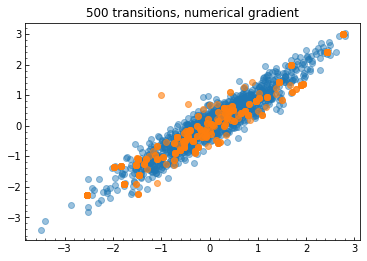

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()

### Look at the leapfrog integrator to tune hyperparameters

In [12]:
x0 = np.array([-1., 1.])
p0 = np.random.randn(*np.array(x0).shape)
x, p = x0, p0
x_arr = []
p_arr = []
for i in range(n_leapfrog_steps):
    lf_out = hmc._leapfrog_fn(x, p, i)
    x, p = lf_out
    x_arr.append(x)
    p_arr.append(p)
x_arr = np.array(x_arr)
p_arr = np.array(p_arr)

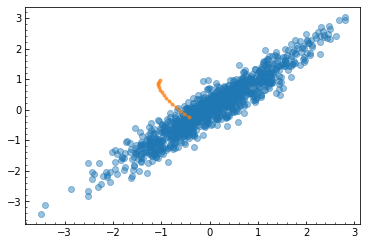

In [14]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(x_arr[:,0], x_arr[:,1], marker='.', ls='-', alpha=0.6)
plt.show()

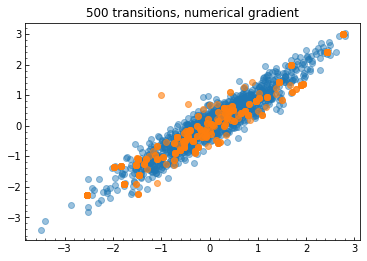

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()